# Task 1.2 DataPreparation

In [133]:
import math
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

First of all, we upload the clean datasets obtained in the Data Understanding section.

In [134]:
df_incidents = pd.read_csv('../datasets_clean/incidents_clean.csv', sep=',', index_col=0)
df_poverty = pd.read_csv('../datasets_clean/poverty_clean.csv', sep=',', index_col=0)
df_elections = pd.read_csv('../datasets_clean/elections_clean.csv', sep=',', index_col=0)

## Data casting
We cast the columns to proper datatypes.

In [135]:
# Let's see the types of the columns of the incidents dataset
df_incidents.dtypes

date                          object
state                         object
city_or_county                object
address                       object
latitude                     float64
longitude                    float64
congressional_district       float64
avg_age_participants         float64
n_participants_child         float64
n_participants_teen          float64
n_participants_adult         float64
n_males                      float64
n_females                    float64
n_killed                       int64
n_injured                      int64
n_arrested                   float64
n_unharmed                   float64
n_participants               float64
incident_characteristics1     object
dtype: object

In [136]:
df_incidents['date'] = pd.to_datetime(df_incidents['date'])
df_incidents['state'] = df_incidents['state'].astype('string')
df_incidents['city_or_county'] = df_incidents['city_or_county'].astype('string')
df_incidents['city_or_county'] = df_incidents['city_or_county'].astype('string')
df_incidents['incident_characteristics1']=df_incidents['incident_characteristics1'].astype('string')
df_incidents['address'] = df_incidents['address'].astype('string')

In [137]:
# Let's see the types of the columns of the poverty dataset
df_poverty.dtypes

state                 object
year                   int64
povertyPercentage    float64
dtype: object

In [138]:
df_poverty['year'] = df_poverty['year'].astype('float64')
df_poverty['state']=df_poverty['state'].astype('string')

In [139]:
# Let's see the types of the columns of the elections dataset
df_elections.dtypes

year                        int64
state                      object
congressional_district      int64
party                      object
candidatevotes            float64
totalvotes                float64
dtype: object

In [140]:
df_elections['year'] = df_elections['year'].astype('float64')
df_elections['congressional_district']=df_elections['congressional_district'].astype('float64')
df_elections['state']=df_elections['state'].astype('string')

## Distribution of the features

In [141]:
# Let's see the distribution of the features of the incidents dataset
df_incidents.head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1
0,2015-05-02,Indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured
1,2017-04-03,Pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,62.0,0.0,0.0,1.0,1.0,0.0,1,0,0.0,0.0,1.0,"Shot - Dead (murder, accidental, suicide)"
3,2016-10-15,District of Columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,26.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,2.0,Shot - Wounded/Injured
4,NaT,Pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,40.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,1.0,2.0,Shot - Wounded/Injured
5,2014-01-18,North Carolina,Wayne County,4700 block of U.S. Highway 70 East,35.1847,-77.9527,13.0,65.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured


### Discretization of ages
We decide to divide the ages into 9 classes in order to better identify the average age of the participants of incidents.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '[18-24]'),
  Text(1, 0, '[25-34]'),
  Text(2, 0, '[35-44]'),
  Text(3, 0, '[45-54]'),
  Text(4, 0, '[12-17]'),
  Text(5, 0, '[55-64]'),
  Text(6, 0, '[65-74]'),
  Text(7, 0, '[0-11]'),
  Text(8, 0, '[75-100]')])

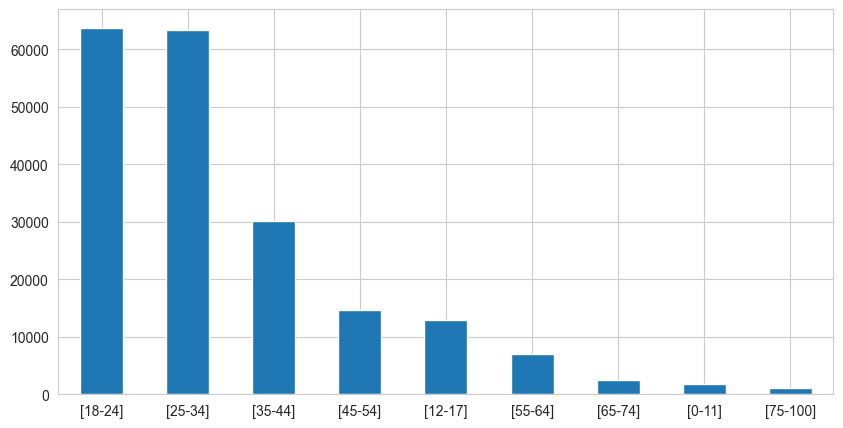

In [142]:
# We want to discretize the feature avg_age_participants in the following classes: [0-11], [12-17], [18-24], [25-34], [35-44], [45-54], [55-64], [65-74], [75-100]
# We create a new feature 'age_group' with the corresponding class
def f(x):
    if x <= 11:
        return '[0-11]'
    elif x <= 17:
        return '[12-17]'
    elif x <= 24:
        return '[18-24]'
    elif x <= 34:
        return '[25-34]'
    elif x <= 44:
        return '[35-44]'
    elif x <= 54:
        return '[45-54]'
    elif x <= 64:
        return '[55-64]'
    elif x <= 74:
        return '[65-74]'
    else:
        return '[75-100]'


df_incidents['age_group'] = df_incidents['avg_age_participants'].apply(f)
# histogram of the age_group
plt.figure(figsize=(10, 5))
df_incidents['age_group'].value_counts().plot(kind='bar')
# make the plot more readable
plt.xticks(rotation=0)

### Incidents' characteristics

<Axes: >

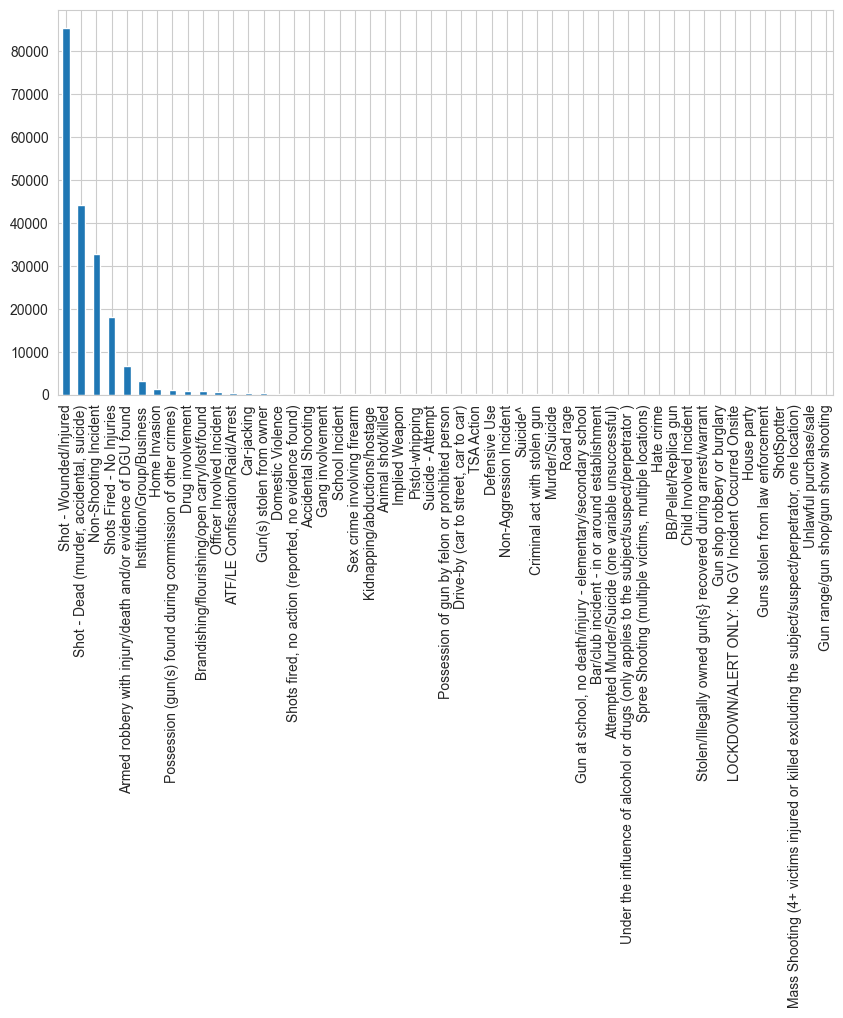

In [143]:
#TODO: va bene create 5 labels per characteristics1?
# Let's see the distribution of the feature characteristics1
plt.figure(figsize=(10, 5))
df_incidents['incident_characteristics1'].value_counts().plot(kind='bar')

We decide to reduce to just 5 labels: the 4 most common characteristics, i.e., 'Shoot-Wounded/Injured', 'Shoot-Dead(murder, accidental, suicide)', 'Non-Shooting Incident', 'Shots Fired-No Injuries', and we set the others to 'Other'.

In [144]:
print(df_incidents['incident_characteristics1'].value_counts().head(4))

Shot - Wounded/Injured                       85424
Shot - Dead (murder, accidental, suicide)    44098
Non-Shooting Incident                        32637
Shots Fired - No Injuries                    17957
Name: incident_characteristics1, dtype: Int64


In [145]:
# Define the four most common values
common_values = ['Shot - Wounded/Injured', 'Shot - Dead (murder, accidental, suicide)', 'Non-Shooting Incident', 'Shots Fired - No Injuries']

# Update values in the 'characteristics1' column
for index, row in df_incidents.iterrows():
    if row['incident_characteristics1'] not in common_values:
        df_incidents.at[index, 'incident_characteristics1'] = 'Other'

<Axes: >

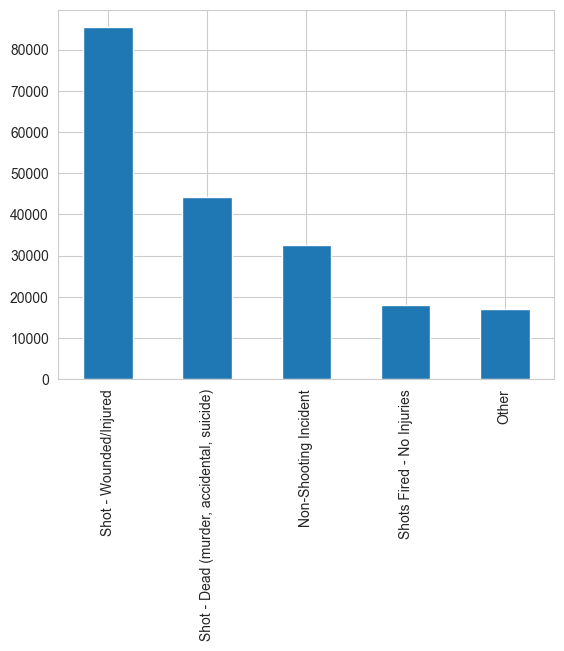

In [146]:
plt.figure(figsize=(10, 5))
df_incidents['incident_characteristics1'].value_counts().plot(kind='bar')

## Joining datasets
We also decided to join the incidents and poverty datasets in order to have, associated to each incident, the poverty percentage of that state in the year the incident occurred. Then, we joined the incidents and elections datasets, so that for each incident we have the data related to the election happened in the year, state, and congressional district of the incident. Notice that we have the election data just for the even years.


In [147]:
# We start by creating a temporary column 'year' in df_incidents
df_incidents['year']=df_incidents['date'].dt.year

In [148]:
# Then, we join the datasets
df_incidents = pd.merge(df_incidents, df_poverty, on=['state', 'year'], how='left')

In [149]:
df_incidents.head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,...,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,age_group,year,povertyPercentage
0,2015-05-02,Indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,...,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured,[18-24],2015.0,12.3
1,2017-04-03,Pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,62.0,0.0,0.0,...,0.0,1,0,0.0,0.0,1.0,"Shot - Dead (murder, accidental, suicide)",[55-64],2017.0,10.5
2,2016-10-15,District of Columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,26.0,0.0,0.0,...,0.0,0,1,0.0,0.0,2.0,Shot - Wounded/Injured,[25-34],2016.0,14.9
3,NaT,Pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,40.0,0.0,0.0,...,0.0,0,1,0.0,1.0,2.0,Shot - Wounded/Injured,[35-44],NaN,NaN
4,2014-01-18,North Carolina,Wayne County,4700 block of U.S. Highway 70 East,35.1847,-77.9527,13.0,65.0,0.0,0.0,...,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured,[65-74],2014.0,15.3


Since the 'congressional_district' feature in the elections dataset has value 0 if there is a single district in the state, and in the incidents dataset it has value 1 in such case, we have to adjust the values in the elections dataset before joining.

In [150]:
df_elections['congressional_district'] = df_elections['congressional_district'].replace(0, 1)

In [151]:
# We uniform the data types of the columns to be joined
df_incidents['year'] = df_incidents['year'].astype('float64')
df_incidents['congressional_district']=df_incidents['congressional_district'].astype('float64')

In [152]:
# We convert the state columns of the elections dataset to lowercase
df_incidents['state'] = df_incidents['state'].str.lower() 
df_elections['state'] = df_elections['state'].str.lower()

In [153]:
# We join the datasets
df_incidents = pd.merge(df_incidents, df_elections, on=['state', 'congressional_district', 'year'], how='left')
df_incidents.head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,...,n_arrested,n_unharmed,n_participants,incident_characteristics1,age_group,year,povertyPercentage,party,candidatevotes,totalvotes
0,2015-05-02,indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,...,0.0,0.0,1.0,Shot - Wounded/Injured,[18-24],2015.0,12.3,NaN,NaN,NaN
1,2017-04-03,pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,62.0,0.0,0.0,...,0.0,0.0,1.0,"Shot - Dead (murder, accidental, suicide)",[55-64],2017.0,10.5,NaN,NaN,NaN
2,2016-10-15,district of columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,26.0,0.0,0.0,...,0.0,0.0,2.0,Shot - Wounded/Injured,[25-34],2016.0,14.9,NaN,NaN,NaN
3,NaT,pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,40.0,0.0,0.0,...,0.0,1.0,2.0,Shot - Wounded/Injured,[35-44],NaN,NaN,NaN,NaN,NaN
4,2014-01-18,north carolina,Wayne County,4700 block of U.S. Highway 70 East,35.1847,-77.9527,13.0,65.0,0.0,0.0,...,0.0,0.0,1.0,Shot - Wounded/Injured,[65-74],2014.0,15.3,REPUBLICAN,153991.0,268709.0


In [154]:
# Columns of the incidents dataset
df_incidents.columns

Index(['date', 'state', 'city_or_county', 'address', 'latitude', 'longitude',
       'congressional_district', 'avg_age_participants',
       'n_participants_child', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'incident_characteristics1',
       'age_group', 'year', 'povertyPercentage', 'party', 'candidatevotes',
       'totalvotes'],
      dtype='object')

In [155]:
# We drop the 'year' column
df_incidents.drop(['year'], axis=1, inplace=True)

# Definition of new indicators

## Severity of the incident
We start considering the ratio of killed and injured participants in the incidents with respect to the sum of killed, injured and unharmed participants (we didn't consider the total number of participants since in some cases there is a mismatch in these values). Then, we define the _severity_ of the incidents as the weighted mean of the ratios just defined. We assign to `ratio_killed` the weight 0.7, and to `ratio_injured` the weight 0.3.

In [156]:
total = df_incidents['n_killed'] + df_incidents['n_injured'] + df_incidents['n_unharmed']
df_incidents['ratio_killed'] = df_incidents['n_killed']/total*100
df_incidents['ratio_injured'] = df_incidents['n_injured']/total*100
df_incidents['ratio_unharmed'] = df_incidents['n_unharmed']/total*100

In [157]:
df_incidents['severity'] = 0.7*df_incidents['ratio_killed'] + 0.3*df_incidents['ratio_injured']

In [158]:
df_incidents['severity'].describe()

count    162068.000000
mean         32.346780
std          23.904806
min           0.000000
25%          15.000000
50%          30.000000
75%          50.000000
max          70.000000
Name: severity, dtype: float64

Text(0.5, 1.0, 'Distribution of the severity')

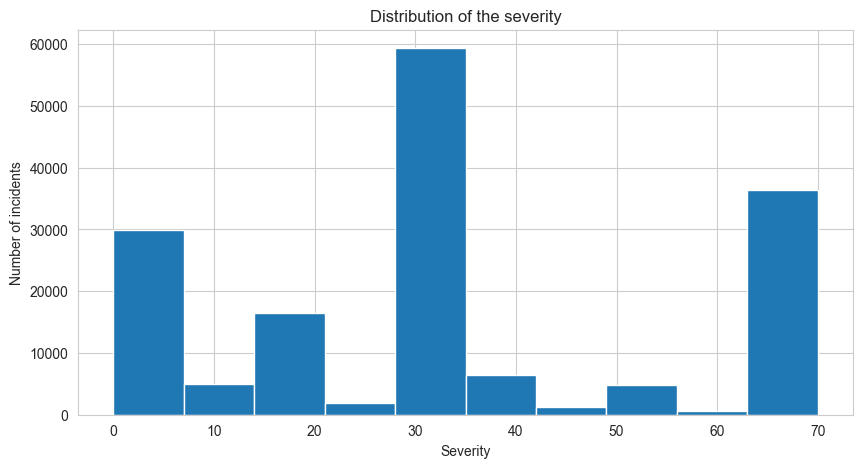

In [159]:
# distribution of the severity
plt.figure(figsize=(10,5))
plt.hist(df_incidents['severity'], bins=10)
plt.xlabel('Severity')
plt.ylabel('Number of incidents')
plt.title('Distribution of the severity')

Looking at the histogram it is clear that there are 3 main peaks: one around 0, one around 30, and one around 70. We decide to define a categorical feature with values 'low', 'medium', 'high' based on the severity. We assign 'low' to those with severity <=20, 'medium' to those with severity <=40, and 'high' to the others.

Text(0.5, 1.0, 'Distribution of the severity')

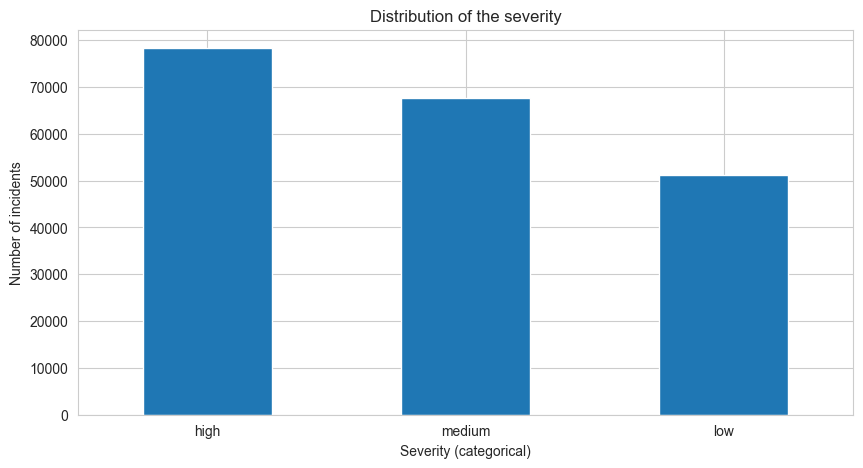

In [160]:
# Assign low to those with severity <=20, medium to those with severity <=40, high to the others
def f(x):
    if x<=20:
        return 'low'
    elif x<=40:
        return 'medium'
    else:
        return 'high'
df_incidents['severity_cat'] = df_incidents['severity'].apply(f)
# plot the distribution of the severity_cat
plt.figure(figsize=(10,5))
df_incidents['severity_cat'].value_counts().plot(kind='bar')
# make the plot more readable
plt.xticks(rotation=0)
plt.xlabel('Severity (categorical)')
plt.ylabel('Number of incidents')
plt.title('Distribution of the severity')


In [161]:
# We drop the columns of the ratios
df_incidents.drop(['ratio_killed', 'ratio_injured', 'ratio_unharmed'], axis=1, inplace=True)

In [162]:
# Columns of the incidents dataset
df_incidents.columns

Index(['date', 'state', 'city_or_county', 'address', 'latitude', 'longitude',
       'congressional_district', 'avg_age_participants',
       'n_participants_child', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'incident_characteristics1',
       'age_group', 'povertyPercentage', 'party', 'candidatevotes',
       'totalvotes', 'severity', 'severity_cat'],
      dtype='object')

In [163]:
#TODO: eliminare la feature 'severity' e lasciare solo severity_cat?

## Injured and killed in a given place and time
We investigate how many injured and killed people have been involved w.r.t the total injured and killed people in the same congressional district (and state) in a month.

In [163]:
# TODO: forse si può eliminare?
df_incidents.date=pd.to_datetime(df_incidents.date)

In [164]:
# We group the incidents by state, congressional district, year-month, and we sum the number of killed people
df_incidents['year_month'] = df_incidents.date.dt.strftime('%y-%m')
df_incidents.year_month.isnull().sum()
tot_killed = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_killed'].sum()

# Convert the Series to a DataFrame and reset the index
tot_killed_df = tot_killed.reset_index()

# Rename the 'n_killed' column to 'total_killed'
tot_killed_df = tot_killed_df.rename(columns={'n_killed': 'total_killed'})

# Print the resulting DataFrame
print(tot_killed_df)


# We do the same for the injured
tot_injured = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_injured'].sum()

# Convert the Series to a DataFrame and reset the index
tot_injured_df = tot_injured.reset_index()

# Rename the 'n_killed' column to 'total_injured'
tot_injured_df = tot_injured_df.rename(columns={'n_injured': 'total_injured'})

         state  congressional_district year_month  total_killed
0      alabama                     1.0      14-01             3
1      alabama                     1.0      14-02             5
2      alabama                     1.0      14-03             3
3      alabama                     1.0      14-04             3
4      alabama                     1.0      14-05             7
...        ...                     ...        ...           ...
21112  wyoming                     1.0      17-05             0
21113  wyoming                     1.0      17-06             0
21114  wyoming                     1.0      17-07             0
21115  wyoming                     1.0      17-08             3
21116  wyoming                     1.0      17-09             1

[21117 rows x 4 columns]


In [165]:
# We join the 'total_killed' and 'total_injured' columns to the incidents dataset
df_incidents =pd.merge( df_incidents, tot_killed_df, on=['state', 'congressional_district', 'year_month'])
df_incidents = pd.merge(df_incidents, tot_injured_df, on=['state', 'congressional_district', 'year_month'])

df_incidents.head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,...,age_group,povertyPercentage,party,candidatevotes,totalvotes,severity,severity_cat,year_month,total_killed,total_injured
0,2015-05-02,indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,...,[18-24],12.3,NaN,NaN,NaN,30.0,medium,15-05,3,4
1,2015-05-03,indiana,Indianapolis,502 N. Rural Street,39.7745,-86.1166,7.0,32.0,0.0,0.0,...,[25-34],12.3,NaN,NaN,NaN,70.0,high,15-05,3,4
2,2015-05-25,indiana,Indianapolis,800 block of Chapelwood Boulevard,39.7759,-86.2940,7.0,36.0,0.0,0.0,...,[35-44],12.3,NaN,NaN,NaN,70.0,high,15-05,3,4
3,2015-05-03,indiana,Indianapolis,East 25th Street and North Post Road,39.8040,-86.0095,7.0,18.0,0.0,0.0,...,[18-24],12.3,NaN,NaN,NaN,70.0,high,15-05,3,4
4,2015-05-30,indiana,Indianapolis,3018 West 16th Street,39.7882,-86.2091,7.0,53.0,0.0,0.0,...,[45-54],12.3,NaN,NaN,NaN,30.0,medium,15-05,3,4


We define the features 'killed_by_district' and 'injured_by_district' as the ratio of killed and injured people in the incident w.r.t. the total killed and injured people in the same congressional district (and state) in the same year-month. We impose that these features have value 0 if 'total_killed' or 'total_injured' is 0.

In [166]:
# We distinguish between the case with total_killed = 0, and total_killed != 0
def f(x, y):
    if y!=0:
        return x/y
    else:
        return 0
df_incidents['killed_by_district'] = df_incidents.apply(lambda row: f(row['n_killed'], row['total_killed']), axis=1)

df_incidents['injured_by_district'] = df_incidents.apply(lambda row: f(row['n_injured'], row['total_injured']), axis=1)

(array([ 9667., 11578.,  5210.,  6484.,  6517.,    92.,   698.,   141.,
           16.,  5894.]),
 array([0.01639344, 0.1147541 , 0.21311475, 0.31147541, 0.40983607,
        0.50819672, 0.60655738, 0.70491803, 0.80327869, 0.90163934,
        1.        ]),
 <BarContainer object of 10 artists>)

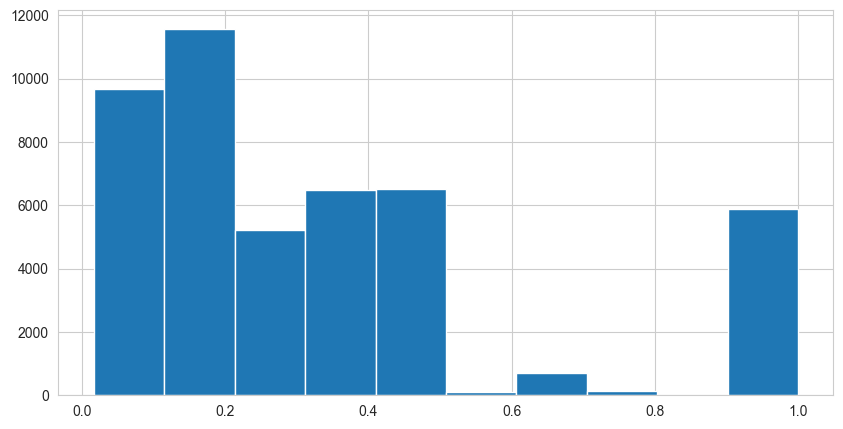

In [167]:
# Let's see the distribution of the feature 'killed_by_district'
plt.figure(figsize=(10, 5))
plt.hist(df_incidents.killed_by_district[df_incidents['killed_by_district']!=0], bins=10)

(array([135404.,  16050.,   6892.,    918.,   5243.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <BarContainer object of 5 artists>)

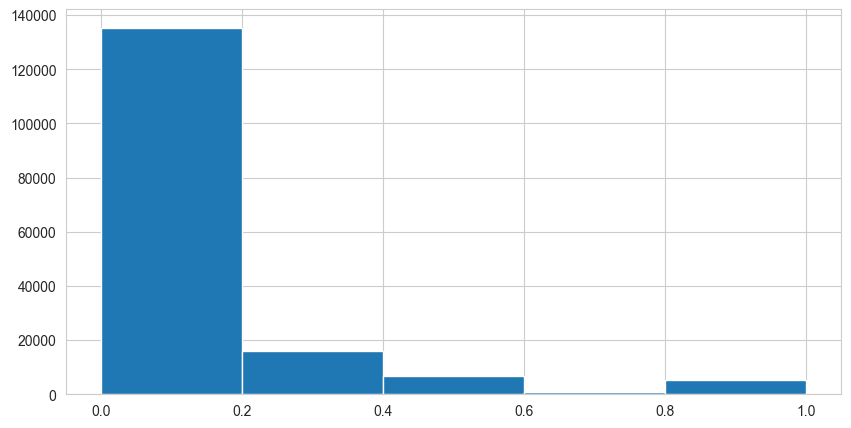

In [168]:
plt.figure(figsize=(10, 5))
plt.hist(df_incidents['injured_by_district'], bins=5)

## Another index

In [169]:
# TODO: fare un altro indice consigliato da monreale

## Ratio of voters

# Correlation matrix of the features

# Final Datasets

In [172]:
# Let's see the final datasets
df_incidents.head()

In [173]:
df_poverty.head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,...,candidatevotes,totalvotes,severity,severity_cat,year_month,total_killed,total_injured,killed_by_district,injured_by_district,female_ratio
0,2015-05-02,indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,...,NaN,NaN,30.0,medium,15-05,3,4,0.000000,0.25,0.0
1,2015-05-03,indiana,Indianapolis,502 N. Rural Street,39.7745,-86.1166,7.0,32.0,0.0,0.0,...,NaN,NaN,70.0,high,15-05,3,4,0.333333,0.00,0.0
2,2015-05-25,indiana,Indianapolis,800 block of Chapelwood Boulevard,39.7759,-86.2940,7.0,36.0,0.0,0.0,...,NaN,NaN,70.0,high,15-05,3,4,0.333333,0.00,0.0
3,2015-05-03,indiana,Indianapolis,East 25th Street and North Post Road,39.8040,-86.0095,7.0,18.0,0.0,0.0,...,NaN,NaN,70.0,high,15-05,3,4,0.333333,0.00,0.0
4,2015-05-30,indiana,Indianapolis,3018 West 16th Street,39.7882,-86.2091,7.0,53.0,0.0,0.0,...,NaN,NaN,30.0,medium,15-05,3,4,0.000000,0.25,0.0


In [174]:
df_elections.head()

,state,year,povertyPercentage
0,United States,2020.0,11.5
1,Alabama,2020.0,14.8
2,Alaska,2020.0,11.5
3,Arizona,2020.0,12.1
4,Arkansas,2020.0,15.8


,year,state,congressional_district,party,candidatevotes,totalvotes
0,1976.0,alabama,1.0,REPUBLICAN,98257.0,157170.0
1,1976.0,alabama,2.0,REPUBLICAN,90069.0,156362.0
2,1976.0,alabama,3.0,DEMOCRAT,106935.0,108048.0
3,1976.0,alabama,4.0,DEMOCRAT,141490.0,176022.0
4,1976.0,alabama,5.0,DEMOCRAT,113553.0,113560.0


# Aggregated dataset

We group the incidents that happened in the same congressional district of each state: label [state, congressional district] (and eventually in the same year, month).

We consider the numerical features of the dataset df_incidents:
- the mean of 'avg_age_participants'
- the sum of the features 'n_participants_child'-'n_participants'

We also add the 'povertyPercentage' feature of df_poverty for each state, year.

Finally, given the year of the incident, we add the 'party', 'candidatevotes', 'totalvotes' features from the dataset df_elections for each [state, congressional district].

In [176]:
# aggregated dataset creation
# n. of incidents per districts and month
df_incidents_agg = df_incidents.groupby(['state', 'congressional_district', 'year_month']).size().reset_index(name='n_incidents')
df_incidents_agg.head()

SyntaxError: invalid syntax (1925158597.py, line 1)

In [ ]:
#TODO : age groups
#TODO : severity index based on age/age group with children or teens involved being more severe
#TODO: ratio candidatevotes/totalvotes
#TODO: Interestingly, the vast majority of the incidents belongs to one between: Shoot-Wounded/Injured, Shoot-Dead(murder, accidental, suicide), Non-Shooting Incident, Shots Fired-No Injuries. Given this fact we could think of aggregate in just one label the other typologies, as we will see in the preparation phase. These information could also be taken as labels for a prediction task.

In [ ]:
# aggregated dataset creation
# n. of incidents per districts and month
df_incidents_agg = df_incidents.groupby(['state', 'congressional_district', 'year_month']).size().reset_index(name='n_incidents')
df_incidents_agg.head()
df_incidents_agg['n_participants'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_participants'].sum().reset_index(name='n_participants')['n_participants']
df_incidents_agg['n_killed'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_killed'].sum().reset_index(name='n_killed')['n_killed']
df_incidents_agg['n_injured'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_injured'].sum().reset_index(name='n_injured')['n_injured']
df_incidents_agg['n_unharmed'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_unharmed'].sum().reset_index(name='n_unharmed')['n_unharmed']
df_incidents_agg['n_participants_child'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_participants_child'].sum().reset_index(name='n_participants_child')['n_participants_child']
df_incidents_agg['n_participants_teen'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_participants_teen'].sum().reset_index(name='n_participants_teen')['n_participants_teen']
df_incidents_agg['n_participants_adult'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_participants_adult'].sum().reset_index(name='n_participants_adult')['n_participants_adult']
df_incidents_agg['avg_age_participants'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['avg_age_participants'].mean().reset_index(name='avg_age_participants')['avg_age_participants']
# year and month
df_incidents_agg['year'] = df_incidents_agg['year_month'].str[0:2]
df_incidents_agg['month'] = df_incidents_agg['year_month'].str[3:5]
df_incidents_agg['year'] = df_incidents_agg['year'].astype('int64')
df_incidents_agg['month'] = df_incidents_agg['month'].astype('int64')
df_incidents_agg['year']+=2000
df_incidents_agg.head()
df_incidents_agg['congressional_district'].replace(0, 1, inplace=True)

# join with elections on state and congressional district
df_elections['state'] = df_elections['state'].str.lower()
df_elections['year'] = df_elections['year'].astype('int64')
df_incidents_agg = pd.merge(df_incidents_agg, df_elections, on=['state', 'congressional_district', 'year'], how='left')
# join with poverty on state and year
df_poverty['year'] = df_poverty['year'].astype('int64')
df_poverty['state'] = df_poverty['state'].str.lower()
df_incidents_agg = pd.merge(df_incidents_agg, df_poverty, on=['state', 'year'], how='left')
df_incidents_agg
# fill the missing values of 'party', 'candidatevotes', 'totalvotes' with data from the previous year, same state and same congressional district
def fill_with_previous_year(row):
    if pd.isnull(row['party']):
        # find the previous year
        previous_year = row['year']-1
        # find the previous row
        previous_row = df_incidents_agg[(df_incidents_agg['state']==row['state']) & (df_incidents_agg['congressional_district']==row['congressional_district']) & (df_incidents_agg['year']==previous_year)]
        if previous_row.shape[0]>0:
            # fill the missing values with the values of the previous row
            row['party'] = previous_row['party'].values[0]
            row['candidatevotes'] = previous_row['candidatevotes'].values[0]
            row['totalvotes'] = previous_row['totalvotes'].values[0]
        elif row['congressional_district']==0:
            # fill with the sum of the values of the same state, previous year
            previous_rows = df_incidents_agg[(df_incidents_agg['state']==row['state']) & (df_incidents_agg['year']==previous_year)]
            if previous_rows.shape[0]>0:
                row['candidatevotes'] = previous_rows['candidatevotes'].sum()
                row['totalvotes'] = previous_rows['totalvotes'].sum()
    return row
# apply the function to the dataframe
df_incidents_agg = df_incidents_agg.apply(fill_with_previous_year, axis=1)
# show two rows one alabama 2014 and one alabama 2015
print(df_incidents_agg.candidatevotes[(df_incidents_agg['state']=='california') & (df_incidents_agg['year']==2016)].head(1))
print(df_incidents_agg.candidatevotes[(df_incidents_agg['state']=='california') & (df_incidents_agg['year']==2017)].head(1))
# show rows with missing values
df_incidents_agg[(df_incidents_agg['party'].isnull()) & (df_incidents_agg['year']!=2013) & (df_incidents_agg['state']!='district of columbia')]